# Lab 4 Amazon Forecast

created by ACZ 202402

## Attribute information

- **InvoiceNo** – Invoice number. Nominal. A 6-digit integral number that's uniquely assigned to each transaction. If this code starts with the letter *c*, it indicates a cancelation.
- **StockCode** – Product (item) code. Nominal. A 5-digit integral number that's uniquely assigned to each distinct product.
- **Description** – Product (item) name. Nominal.
- **Quantity** – The quantities of each product (item) per transaction. Numeric.
- **InvoiceDate** – Invoice date and time. Numeric. The day and time when a transaction was generated.
- **UnitPrice** – Unit price. Numeric. Product price per unit in pounds sterling (£).
- **CustomerID** – Customer number. Nominal. A 5-digit integral number that's uniquely assigned to each customer.
- **Country** – Country name. Nominal. The name of the country where a customer resides.

In [2]:
import warnings
warnings.filterwarnings('ignore')
bucket_name='c109190a2572296l5948528t1w730335490-forecastbucket-iu7ilrtqhvxs'

import boto3
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sagemaker
import time, sys, os, io, json
import xlrd
!pip3 install pandas==1.5.3

In [3]:
retail_raw = pd.read_excel('online_retail_II.xlsx',engine='openpyxl')

In [4]:
# retail.isnull().sum()
retail = retail_raw.dropna()

In [5]:
retail.shape

(417534, 8)

In [6]:
retail.dtypes

Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID           float64
Country                object
dtype: object

In [7]:
retail.head(20)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
5,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,1.65,13085.0,United Kingdom
6,489434,21871,SAVE THE PLANET MUG,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
7,489434,21523,FANCY FONT HOME SWEET HOME DOORMAT,10,2009-12-01 07:45:00,5.95,13085.0,United Kingdom
8,489435,22350,CAT BOWL,12,2009-12-01 07:46:00,2.55,13085.0,United Kingdom
9,489435,22349,"DOG BOWL , CHASING BALL DESIGN",12,2009-12-01 07:46:00,3.75,13085.0,United Kingdom


The following fields are required:

- **item_id** (string) – A unique identifier for the item or product that you want to predict the demand for.
- **timestamp** (timestamp)
- **demand** (float) – The number of sales for that item at the timestamp. It's also the target field that Amazon Forecast generates a forecast for.

In [8]:
retail = retail[['StockCode','Quantity','Price','Country','InvoiceDate']]

In [9]:
retail['InvoiceDate'] = pd.to_datetime(retail.InvoiceDate)
retail = retail.set_index('InvoiceDate')

In [10]:
retail.shape

(417534, 4)

In [11]:
retail.head()

,StockCode,Quantity,Price,Country
InvoiceDate,,,,
2009-12-01 07:45:00,85048,12,6.95,United Kingdom
2009-12-01 07:45:00,79323P,12,6.75,United Kingdom
2009-12-01 07:45:00,79323W,12,6.75,United Kingdom
2009-12-01 07:45:00,22041,48,2.10,United Kingdom
2009-12-01 07:45:00,21232,24,1.25,United Kingdom


In [12]:
retail['2010-01-04']

,StockCode,Quantity,Price,Country
InvoiceDate,,,,
2010-01-04 09:24:00,TEST001,5,4.50,United Kingdom
2010-01-04 09:43:00,21539,-1,4.25,United Kingdom
2010-01-04 09:53:00,TEST001,5,4.50,United Kingdom
2010-01-04 10:28:00,21844,36,2.55,United Kingdom
2010-01-04 10:28:00,21533,12,4.25,United Kingdom
...,...,...,...,...
2010-01-04 17:39:00,90214G,1,1.25,United Kingdom
2010-01-04 17:39:00,90214N,1,1.25,United Kingdom
2010-01-04 17:39:00,90214N,1,1.25,United Kingdom


In [13]:
retail['2010-01':'2010-02']

,StockCode,Quantity,Price,Country
InvoiceDate,,,,
2010-01-04 09:24:00,TEST001,5,4.50,United Kingdom
2010-01-04 09:43:00,21539,-1,4.25,United Kingdom
2010-01-04 09:53:00,TEST001,5,4.50,United Kingdom
2010-01-04 10:28:00,21844,36,2.55,United Kingdom
2010-01-04 10:28:00,21533,12,4.25,United Kingdom
...,...,...,...,...
2010-02-28 16:14:00,84279B,1,3.75,United Kingdom
2010-02-28 16:14:00,84882,1,3.75,United Kingdom
2010-02-28 16:14:00,84882,1,3.75,United Kingdom


In [14]:
retail.index.min()

Timestamp('2009-12-01 07:45:00')

In [15]:
retail.index.max()

Timestamp('2010-12-09 20:01:00')

In [16]:
retail['Year'] = retail.index.year
retail['Month'] = retail.index.month
retail['weekday_name'] = retail.index.day_name()

In [17]:
retail.head()

,StockCode,Quantity,Price,Country,Year,Month,weekday_name
InvoiceDate,,,,,,,
2009-12-01 07:45:00,85048,12,6.95,United Kingdom,2009,12,Tuesday
2009-12-01 07:45:00,79323P,12,6.75,United Kingdom,2009,12,Tuesday
2009-12-01 07:45:00,79323W,12,6.75,United Kingdom,2009,12,Tuesday
2009-12-01 07:45:00,22041,48,2.10,United Kingdom,2009,12,Tuesday
2009-12-01 07:45:00,21232,24,1.25,United Kingdom,2009,12,Tuesday


<Axes: >

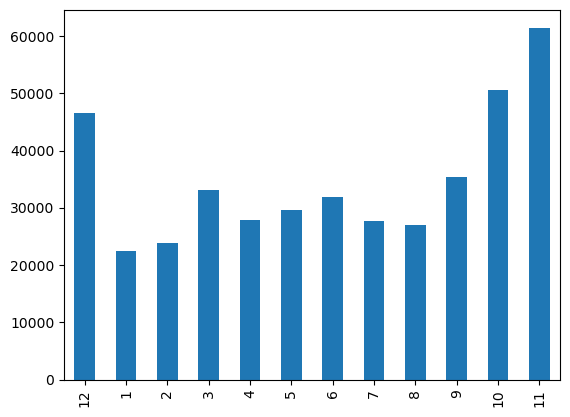

In [18]:
retail.Month.value_counts(sort=False).plot(kind='bar')

1. November and December seem to be higher than the rest of the year.
2. Q4 seems to be higher than other quarters.
3. For Q1, Q2, and Q3: The last month of the quarter (months 3, 6, and 9) seem to have spikes.

<Axes: >

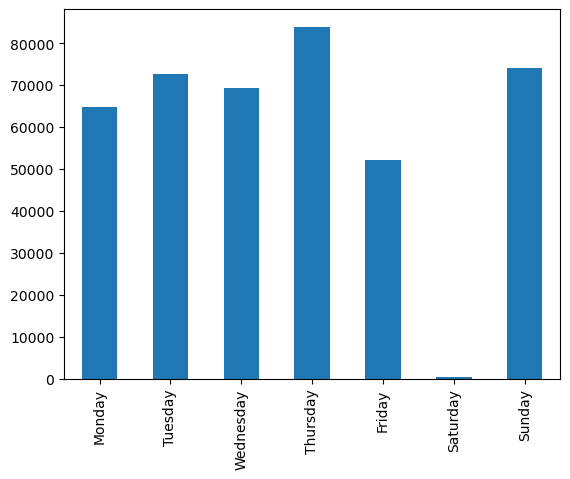

In [19]:
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
retail.weekday_name.value_counts(sort=False).loc[day_order].plot(kind='bar')

Very low orders at Saturday<br>
Probably day-off/closed at Saturday

In [20]:
retail.Country.unique()

array(['United Kingdom', 'France', 'USA', 'Belgium', 'Australia', 'EIRE',
       'Germany', 'Portugal', 'Japan', 'Denmark', 'Netherlands', 'Poland',
       'Spain', 'Channel Islands', 'Italy', 'Cyprus', 'Greece', 'Norway',
       'Austria', 'Sweden', 'United Arab Emirates', 'Finland',
       'Switzerland', 'Unspecified', 'Nigeria', 'Malta', 'RSA',
       'Singapore', 'Bahrain', 'Thailand', 'Israel', 'Lithuania',
       'West Indies', 'Korea', 'Brazil', 'Canada', 'Iceland'],
      dtype=object)

In [21]:
retail.Country.value_counts()

United Kingdom          379423
EIRE                      8710
Germany                   8129
France                    5710
Netherlands               2769
Spain                     1278
Switzerland               1187
Belgium                   1054
Portugal                  1024
Channel Islands            906
Sweden                     883
Italy                      731
Australia                  654
Cyprus                     554
Austria                    537
Greece                     517
Denmark                    428
Norway                     369
Finland                    354
United Arab Emirates       318
Unspecified                280
USA                        244
Japan                      224
Poland                     194
Malta                      172
Lithuania                  154
Singapore                  117
Canada                      77
Thailand                    76
Israel                      74
Iceland                     71
RSA                         65
Korea   

In [22]:
country_filter = ['United Kingdom']
retail = retail[retail.Country.isin(country_filter)]

In [23]:
retail = retail[['StockCode','Quantity','Price']]

In [24]:
retail.head()

,StockCode,Quantity,Price
InvoiceDate,,,
2009-12-01 07:45:00,85048,12,6.95
2009-12-01 07:45:00,79323P,12,6.75
2009-12-01 07:45:00,79323W,12,6.75
2009-12-01 07:45:00,22041,48,2.10
2009-12-01 07:45:00,21232,24,1.25


In [25]:
retail.StockCode.describe()

count     379423
unique      4015
top       85123A
freq        3140
Name: StockCode, dtype: object

<Axes: >

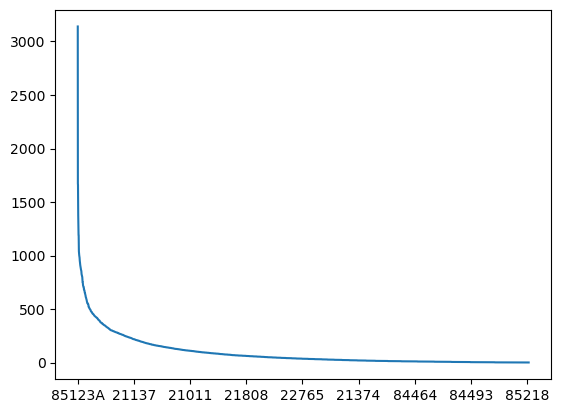

In [26]:
retail.StockCode.value_counts().plot()

In [27]:
retail.Quantity.describe()

count    379423.000000
mean         11.451517
std          68.943709
min       -9360.000000
25%           2.000000
50%           4.000000
75%          12.000000
max       10000.000000
Name: Quantity, dtype: float64

<Axes: xlabel='InvoiceDate'>

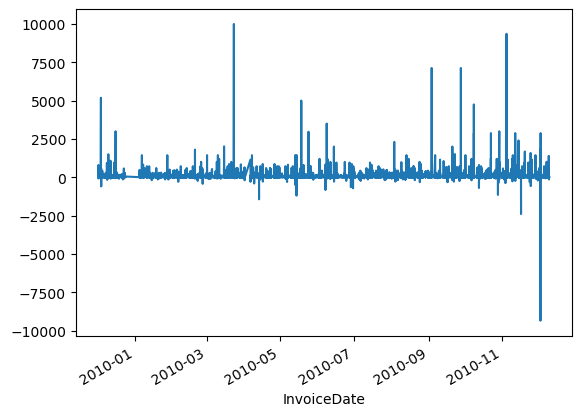

In [28]:
retail.Quantity.plot()

In [29]:
retail = retail[retail.Quantity>0]

In [30]:
retail.Price.describe()

count    370951.000000
mean          3.145220
std          30.551482
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max       10953.500000
Name: Price, dtype: float64

<Axes: xlabel='InvoiceDate'>

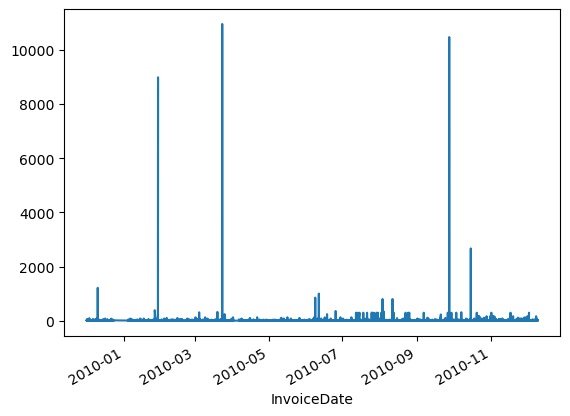

In [31]:
retail.Price.plot()

In [32]:
retail[retail.Price>500].head(20)

,StockCode,Quantity,Price
InvoiceDate,,,
2009-12-10 11:50:00,M,1,1213.02
2010-01-29 11:04:00,M,1,8985.60
2010-03-23 15:22:00,M,1,10953.50
2010-06-08 16:39:00,M,1,849.45
2010-06-11 15:54:00,M,1,1000.63
2010-08-03 10:52:00,M,1,800.00
2010-08-11 15:56:00,M,1,800.00
2010-09-27 16:12:00,M,1,10468.80
2010-09-27 16:18:00,M,1,2769.90


In [33]:
retail = retail[retail.StockCode!='M']

<Axes: xlabel='InvoiceDate'>

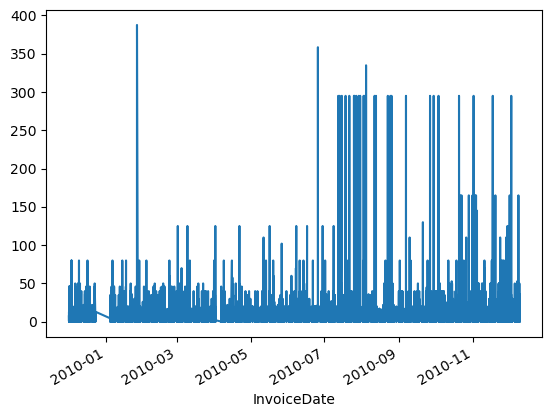

In [35]:
retail.Price.plot()

In [36]:
retail.Price.describe()

count    370576.000000
mean          3.009463
std           4.576951
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max         387.540000
Name: Price, dtype: float64

In [37]:
retail[retail.Price>300].head(20)

,StockCode,Quantity,Price
InvoiceDate,,,
2010-01-26 16:29:00,ADJUST,1,342.80
2010-01-26 17:28:00,ADJUST,1,387.54
2010-06-25 14:15:00,ADJUST2,1,300.13
2010-06-25 14:15:00,ADJUST2,1,358.47
2010-08-04 11:38:00,POST,1,334.88


In [38]:
stockcodes = ['ADJUST', 'ADJUST2', 'POST']
retail = retail[~retail.StockCode.isin(stockcodes)]

<Axes: xlabel='InvoiceDate'>

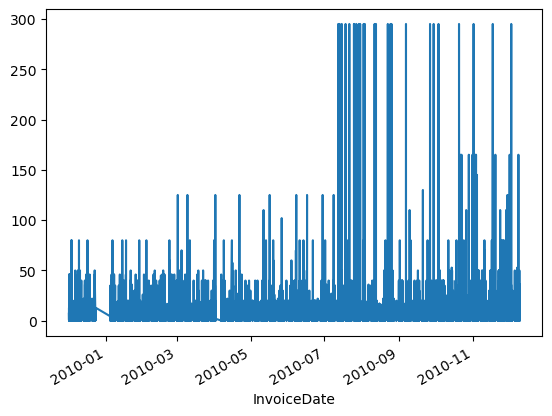

In [39]:
retail.Price.plot()

In [40]:
retail.Price.describe()

count    370554.000000
mean          3.002500
std           4.363688
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max         295.000000
Name: Price, dtype: float64

In [41]:
retail[retail.Price==0].count

<bound method DataFrame.count of                     StockCode  Quantity  Price
InvoiceDate                                   
2009-12-02 13:34:00     22076        12    0.0
2009-12-03 11:19:00     48185         2    0.0
2009-12-08 15:25:00     22065         1    0.0
2009-12-08 15:25:00     22142        12    0.0
2009-12-15 13:49:00     85042         8    0.0
2009-12-18 14:22:00     21143        12    0.0
2010-01-06 14:54:00     79320        24    0.0
2010-01-15 12:43:00     21533        12    0.0
2010-02-12 14:58:00   TEST001         5    0.0
2010-02-12 15:47:00   TEST001         5    0.0
2010-03-04 11:44:00     21662         1    0.0
2010-04-01 17:13:00     22459         8    0.0
2010-04-01 17:13:00     22458         8    0.0
2010-06-11 11:12:00     21765         1    0.0
2010-06-17 10:12:00     20914         2    0.0
2010-06-24 12:34:00     22423         5    0.0
2010-07-19 13:13:00     22690         6    0.0
2010-09-27 16:59:00    46000M       648    0.0
2010-09-30 12:19:00     222

In [43]:
retail = retail[retail.Price>0]

In [44]:
retail.shape

(370533, 3)

In [45]:
df_time_series = retail[['StockCode','Quantity']]
df_related_time_series = retail[['StockCode','Price']]

In [46]:
df_time_series[df_time_series.StockCode==21232]['2009-12-01']

,StockCode,Quantity
InvoiceDate,,
2009-12-01 07:45:00,21232,24
2009-12-01 10:49:00,21232,48
2009-12-01 12:13:00,21232,3
2009-12-01 12:14:00,21232,20
2009-12-01 13:31:00,21232,4
2009-12-01 13:37:00,21232,12
2009-12-01 13:43:00,21232,24
2009-12-01 14:19:00,21232,12
2009-12-01 15:26:00,21232,12


In [47]:
df_time_series = df_time_series.groupby('StockCode').resample('D').sum().reset_index()

In [48]:
df_time_series['InvoiceDate'] = pd.to_datetime(df_time_series.InvoiceDate)
df_time_series = df_time_series.set_index('InvoiceDate')
df_time_series.head()

,StockCode,Quantity
InvoiceDate,,
2009-12-01,10002,12
2009-12-02,10002,0
2009-12-03,10002,7
2009-12-04,10002,25
2009-12-05,10002,0


In [49]:
df_time_series = df_time_series.groupby('StockCode').resample('D').sum().reset_index().set_index(['InvoiceDate'])

In [50]:
df_time_series[df_time_series.StockCode==21232]

,StockCode,Quantity
InvoiceDate,,
2009-12-01,21232,171
2009-12-02,21232,164
2009-12-03,21232,192
2009-12-04,21232,264
2009-12-05,21232,36
...,...,...
2010-12-04,21232,0
2010-12-05,21232,4
2010-12-06,21232,12


In [51]:
df_related_time_series.head()

,StockCode,Price
InvoiceDate,,
2009-12-01 07:45:00,85048,6.95
2009-12-01 07:45:00,79323P,6.75
2009-12-01 07:45:00,79323W,6.75
2009-12-01 07:45:00,22041,2.10
2009-12-01 07:45:00,21232,1.25


In [52]:
df_related_time_series2 = df_related_time_series.groupby('StockCode').resample('D').mean().reset_index().set_index(['InvoiceDate','StockCode'])

In [53]:
df_related_time_series2.head(20)

,,Price
InvoiceDate,StockCode,
2009-12-01,10002,0.85
2009-12-02,10002,NaN
2009-12-03,10002,0.85
2009-12-04,10002,0.85
2009-12-05,10002,NaN
2009-12-06,10002,0.85
2009-12-07,10002,0.85
2009-12-08,10002,NaN
2009-12-09,10002,NaN


In [54]:
retail[retail.StockCode == 10002]['2009-12']

,StockCode,Quantity,Price
InvoiceDate,,,
2009-12-01 09:08:00,10002,12,0.85
2009-12-03 13:49:00,10002,1,0.85
2009-12-03 13:49:00,10002,1,0.85
2009-12-03 19:13:00,10002,1,0.85
2009-12-03 20:03:00,10002,4,0.85
2009-12-04 08:46:00,10002,12,0.85
2009-12-04 12:20:00,10002,12,0.85
2009-12-04 17:31:00,10002,1,0.85
2009-12-06 15:24:00,10002,1,0.85


In [55]:
df_related_time_series3 = df_related_time_series2.groupby('StockCode').pad()

Forward fill the missing value

In [56]:
df_related_time_series3.head(20)

,,Price
InvoiceDate,StockCode,
2009-12-01,10002,0.85
2009-12-02,10002,0.85
2009-12-03,10002,0.85
2009-12-04,10002,0.85
2009-12-05,10002,0.85
2009-12-06,10002,0.85
2009-12-07,10002,0.85
2009-12-08,10002,0.85
2009-12-09,10002,0.85


### Forecast Autorun running in background ... 

In [57]:
import sys

class StatusIndicator:
    
    def __init__(self):
        self.previous_status = None
        self.need_newline = False
        
    def update( self, status ):
        if self.previous_status != status:
            if self.need_newline:
                sys.stdout.write("\n")
            sys.stdout.write( status + " ")
            self.need_newline = True
            self.previous_status = status
        else:
            # sys.stdout.write(".")
            print('.',end='')
            self.need_newline = True
        sys.stdout.flush()

    def end(self):
        if self.need_newline:
            sys.stdout.write("\n")

In [58]:
bucket='mlf-lab4-forecastbucket-12sb9sjex9iv'

session = boto3.Session() 
forecast = session.client(service_name='forecast') 
forecast_query = session.client(service_name='forecastquery')

In [59]:
print('Waiting for the predictor arn to be available')
while True:
    %store -r
    is_local = "forecast_arn" in locals()
    if is_local: break
    print('.',end='')
    time.sleep(10)

print('Waiting for the predictor to be available')
status_indicator_predictor = StatusIndicator()
while True:
    status = forecast.describe_predictor(PredictorArn=predictor_arn)['Status']
    status_indicator_predictor.update(status)
    if status in ('ACTIVE', 'CREATE_FAILED'): break
    time.sleep(10)

status_indicator_predictor.end()
    
print('Waiting for forecast to be available')
status_indicator = StatusIndicator()
while True:
    status = forecast.describe_forecast(ForecastArn=forecast_arn)['Status']
    status_indicator.update(status)
    if status in ('ACTIVE', 'CREATE_FAILED'): break
    time.sleep(10)

status_indicator.end()

Waiting for the predictor arn to be available
...................................................................................................................................................................................................................................................................................Waiting for the predictor to be available
ACTIVE 
Waiting for forecast to be available
CREATE_PENDING ..
CREATE_IN_PROGRESS .........................................................................................................
ACTIVE 


In [60]:
print()
forecast_response = forecast_query.query_forecast(
    ForecastArn=forecast_arn,
    Filters={"item_id":"21232"}
)
print(forecast_response)


{'Forecast': {'Predictions': {'p10': [{'Timestamp': '2010-11-01T00:00:00', 'Value': -11.5225353241}, {'Timestamp': '2010-11-02T00:00:00', 'Value': 28.4542007446}, {'Timestamp': '2010-11-03T00:00:00', 'Value': 0.6409492493}, {'Timestamp': '2010-11-04T00:00:00', 'Value': 22.9499511719}, {'Timestamp': '2010-11-05T00:00:00', 'Value': 12.8035917282}, {'Timestamp': '2010-11-06T00:00:00', 'Value': -9.7075366974}, {'Timestamp': '2010-11-07T00:00:00', 'Value': 10.6902999878}, {'Timestamp': '2010-11-08T00:00:00', 'Value': -2.03698349}, {'Timestamp': '2010-11-09T00:00:00', 'Value': 0.6015701294}, {'Timestamp': '2010-11-10T00:00:00', 'Value': -7.4712715149}, {'Timestamp': '2010-11-11T00:00:00', 'Value': -24.835559845}, {'Timestamp': '2010-11-12T00:00:00', 'Value': -17.5017166138}, {'Timestamp': '2010-11-13T00:00:00', 'Value': -30.1197967529}, {'Timestamp': '2010-11-14T00:00:00', 'Value': -2.4642601013}, {'Timestamp': '2010-11-15T00:00:00', 'Value': 28.218744278}, {'Timestamp': '2010-11-16T00:00:0

In [61]:
actual_df = pd.read_csv(test, names=['InvoiceDate','StockCode','Quantity'])
actual_df['InvoiceDate'] = pd.to_datetime(actual_df.InvoiceDate)
actual_df = actual_df.set_index('InvoiceDate')
actual_df.head()

,StockCode,Quantity
InvoiceDate,,
2010-11-01,21232,0
2010-11-02,21232,60
2010-11-03,21232,130
2010-11-04,21232,255
2010-11-05,21232,24


In [62]:
# stockcode_filter = ['21232']
# actual_df = actual_df[actual_df['StockCode'].isin(stockcode_filter)]

In [64]:
actual_df['StockCode'].value_counts()

21232    39
Name: StockCode, dtype: int64

In [65]:
actual_df.head(20)

,StockCode,Quantity
InvoiceDate,,
2010-11-01,21232,0
2010-11-02,21232,60
2010-11-03,21232,130
2010-11-04,21232,255
2010-11-05,21232,24
2010-11-06,21232,0
2010-11-07,21232,29
2010-11-08,21232,34
2010-11-09,21232,262


<Axes: xlabel='InvoiceDate'>

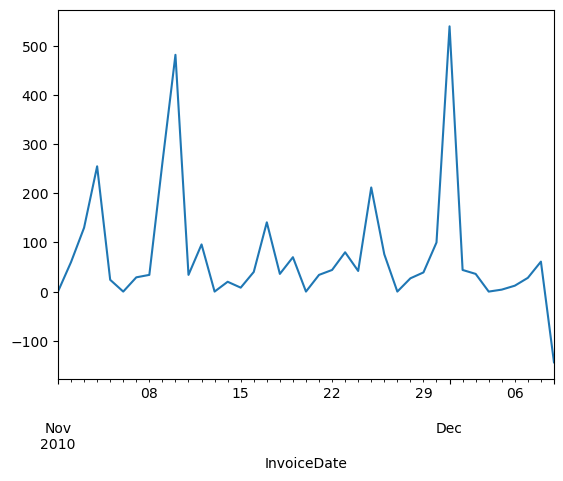

In [66]:
actual_df.Quantity.plot()

In [67]:
# Generate DF 
prediction_df_p10 = pd.DataFrame.from_dict(forecast_response['Forecast']['Predictions']['p10'])
prediction_df_p10.head()

,Timestamp,Value
0,2010-11-01T00:00:00,-11.522535
1,2010-11-02T00:00:00,28.454201
2,2010-11-03T00:00:00,0.640949
3,2010-11-04T00:00:00,22.949951
4,2010-11-05T00:00:00,12.803592


<Axes: >

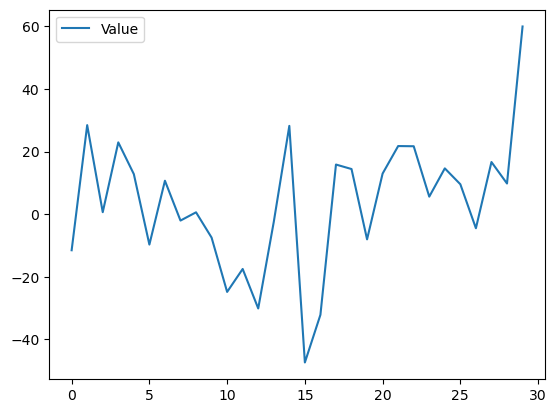

In [68]:
# Plot
prediction_df_p10.plot()

P10 Prediction

<Axes: >

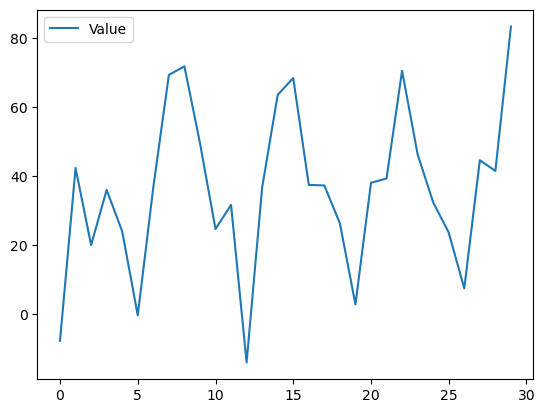

In [69]:
prediction_df_p50 = pd.DataFrame.from_dict(forecast_response['Forecast']['Predictions']['p50'])
prediction_df_p50.plot()

P50 Prediction

<Axes: >

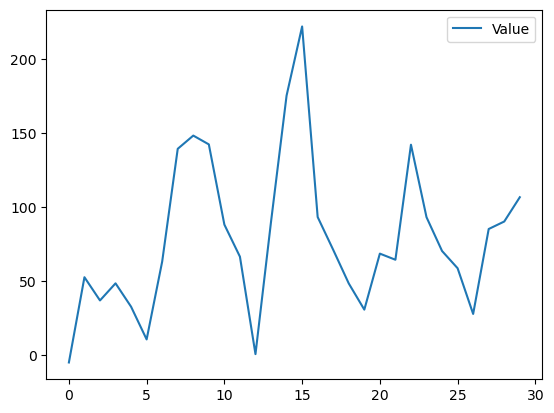

In [70]:
prediction_df_p90 = pd.DataFrame.from_dict(forecast_response['Forecast']['Predictions']['p90'])
prediction_df_p90.plot()

P90 Prediction

In [71]:
# Start by creating a DataFrame to house the content. Here, Source will be which DataFrame it came from.
results_df = pd.DataFrame(columns=['timestamp','value','Source'])

results_df.head()

,timestamp,value,Source


In [72]:
import dateutil.parser
for index, row in actual_df.iterrows():
    #clean_timestamp = dateutil.parser.parse(index)
    results_df = results_df.append({'timestamp' : index , 'value' : row['Quantity'], 'Source': 'Actual'} , ignore_index=True)

In [73]:
# To show the new DataFrame
results_df.head()

,timestamp,value,Source
0,2010-11-01,0,Actual
1,2010-11-02,60,Actual
2,2010-11-03,130,Actual
3,2010-11-04,255,Actual
4,2010-11-05,24,Actual


In [74]:
# Now add the P10, P50, and P90 Values
for index, row in prediction_df_p10.iterrows():
    clean_timestamp = dateutil.parser.parse(row['Timestamp'])
    results_df = results_df.append({'timestamp' : clean_timestamp , 'value' : row['Value'], 'Source': 'p10'} , ignore_index=True)
for index, row in prediction_df_p50.iterrows():
    clean_timestamp = dateutil.parser.parse(row['Timestamp'])
    results_df = results_df.append({'timestamp' : clean_timestamp , 'value' : row['Value'], 'Source': 'p50'} , ignore_index=True)
for index, row in prediction_df_p90.iterrows():
    clean_timestamp = dateutil.parser.parse(row['Timestamp'])
    results_df = results_df.append({'timestamp' : clean_timestamp , 'value' : row['Value'], 'Source': 'p90'} , ignore_index=True)

In [75]:
pivot_df = results_df.pivot(columns='Source', values='value', index="timestamp")
pivot_df

Source,Actual,p10,p50,p90
timestamp,,,,
2010-11-01,0,-11.522535,-7.825202,-4.750973
2010-11-02,60,28.454201,42.283855,52.847042
2010-11-03,130,0.640949,19.936911,37.150909
2010-11-04,255,22.949951,35.927731,48.719147
2010-11-05,24,12.803592,23.886587,32.908997
2010-11-06,0,-9.707537,-0.44122,10.825764
2010-11-07,29,10.6903,36.679199,63.439381
2010-11-08,34,-2.036983,69.281113,139.589523
2010-11-09,262,0.60157,71.781738,148.525055


<Axes: xlabel='timestamp'>

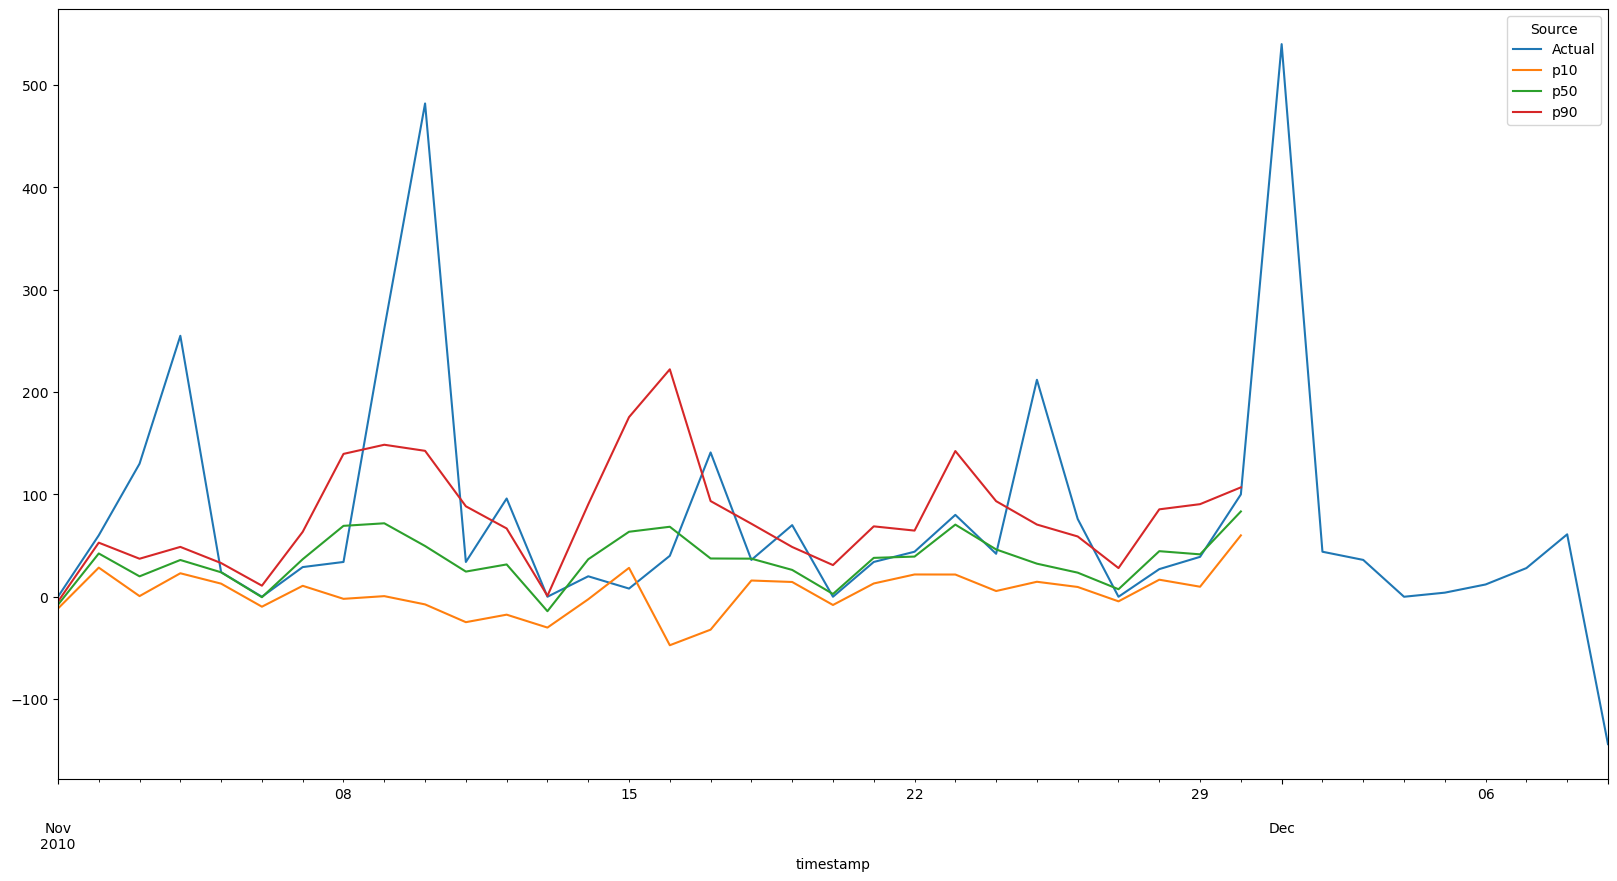

In [76]:
pivot_df.plot(figsize=(20,10))

Prediction comparison between actual, P10, P50, and P90

In [77]:
# End & Cleaning

In [137]:
%store -r

In [138]:
print(forecast_arn)

arn:aws:forecast:us-east-1:730335490427:forecast/lab_4_deeparp_algo_forecast


In [139]:
forecast.delete_forecast(ForecastArn=forecast_arn)
time.sleep(60)

In [140]:
forecast.delete_predictor(PredictorArn=predictor_arn)
time.sleep(60)

In [141]:
forecast.delete_dataset_import_job(DatasetImportJobArn=ds_related_import_job_arn)

{'ResponseMetadata': {'RequestId': '06e2e569-8e98-4e12-b58f-63764a352c44',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Mon, 26 Feb 2024 04:45:44 GMT',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'connection': 'keep-alive',
   'x-amzn-requestid': '06e2e569-8e98-4e12-b58f-63764a352c44'},
  'RetryAttempts': 0}}

In [142]:
forecast.delete_dataset_import_job(DatasetImportJobArn=ds_import_job_arn)

{'ResponseMetadata': {'RequestId': '3bbafee4-d14b-4b4b-9c89-c79d8593cf3f',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Mon, 26 Feb 2024 04:45:44 GMT',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'connection': 'keep-alive',
   'x-amzn-requestid': '3bbafee4-d14b-4b4b-9c89-c79d8593cf3f'},
  'RetryAttempts': 0}}

In [143]:
time.sleep(60)

In [144]:
forecast.delete_dataset(DatasetArn=related_dataset_arn)

{'ResponseMetadata': {'RequestId': '5c39459d-bc4e-41c3-b705-cb033dc5c4f4',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Mon, 26 Feb 2024 04:46:44 GMT',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'connection': 'keep-alive',
   'x-amzn-requestid': '5c39459d-bc4e-41c3-b705-cb033dc5c4f4'},
  'RetryAttempts': 0}}

In [145]:
forecast.delete_dataset(DatasetArn=dataset_arn)

{'ResponseMetadata': {'RequestId': '60e3fb0b-9a27-4f5b-9a61-dfcfb876e500',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Mon, 26 Feb 2024 04:46:44 GMT',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'connection': 'keep-alive',
   'x-amzn-requestid': '60e3fb0b-9a27-4f5b-9a61-dfcfb876e500'},
  'RetryAttempts': 0}}

In [146]:
time.sleep(60)

In [147]:
forecast.delete_dataset_group(DatasetGroupArn=dataset_group_arn)

{'ResponseMetadata': {'RequestId': '14de079e-ff34-4f76-9f47-64000b2b6286',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Mon, 26 Feb 2024 04:47:45 GMT',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'connection': 'keep-alive',
   'x-amzn-requestid': '14de079e-ff34-4f76-9f47-64000b2b6286'},
  'RetryAttempts': 0}}